<a href="https://colab.research.google.com/github/LucaCappelletti94/Master-in-Bioinformatics-and-Functional-genomics/blob/master/image_processing_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline for image processing
The main goal of this Jupyter notebook is to prototype a working pipeline to preprocess chestxrays images.

In [1]:
! git clone https://github.com/LucaCappelletti94/covidxpert

fatal: destination path 'covidxpert' already exists and is not an empty directory.


In [0]:
import os
from glob import glob
import numpy as np
from typing import List
import matplotlib.pyplot as plt

In [0]:
images = glob("covidxpert/sample_dataset/*")

In [0]:
real_bad_path = "covidxpert/sample_dataset/0ffcc21e-3dcb-4ca7-950b-856388a34d65.jpg"
bad_path = "covidxpert/sample_dataset/0b3b1768-5926-4084-bed0-ad9ae886d13a.jpg"
medium_path = "covidxpert/sample_dataset/0abbde89-55e8-4b25-ba9b-17a99f84bae0.jpg"
good_path = "covidxpert/sample_dataset/0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg"

In [0]:
import cv2

def load_image(path:str)->np.ndarray:
  """Return normalized image at given path."""
  image = cv2.imread(path,0)
  image = (image - image.min()) / (image.max() - image.min())
  return np.pad(image, 10)

In [0]:
def get_convex_mask_threshold(image:np.ndarray)->float:
  """Return the threshold curresponding to the histogram peak."""
  counts, values = np.histogram(image, bins=100)
  return values[np.argmax(counts)]

In [0]:
def can_crop(image:np.ndarray, threshold:int=50)->bool:
  """Return a boolean representing if the histogram peak is relatively low."""
  return get_convex_mask_threshold(image) < threshold

In [0]:
from skimage.morphology import convex_hull_image

def convex_mask(image:np.ndarray)->np.ndarray:
  """Return image convex mask."""
  return convex_hull_image(image > 0)

In [0]:
from skimage.feature import corner_harris, corner_peaks, corner_subpix

def get_corners(image:np.ndarray, chull:np.ndarray)->List:
  """Return image corners."""
  return corner_peaks(corner_harris(chull), min_distance=1)

In [0]:
def get_bounding_box_extremes(chull:np.ndarray):
  indexes = np.where(chull > 0)
  min_x, min_y = np.min(indexes, axis=1)
  max_x, max_y = np.max(indexes, axis=1)
  return min_x, min_y, max_x, max_y

In [0]:
def cut_bounding_box(image:np.ndarray, chull:np.ndarray)->np.ndarray:
  """Cut the image using the given bounding box."""
  min_x, min_y, max_x, max_y = get_bounding_box_extremes(chull)
  return image[min_x:max_x, min_y:max_y]

In [0]:
def transpose_corners(corners:np.ndarray, chull:np.ndarray)->np.ndarray:
  min_x, min_y, _, _ = get_bounding_box_extremes(chull)
  return corners - (min_x, min_y)

In [0]:
def sort_corners(corners:np.ndarray)->np.ndarray:
  corners_list = corners.tolist()

  top_left_index = np.argmin(np.sum(corners, axis=1))
  top_left = corners_list[top_left_index]

  bottom_right_index = np.argmax(np.sum(corners, axis=1))
  bottom_right = corners_list[bottom_right_index]

  corners_list.remove(bottom_right)
  corners_list.remove(top_left)

  corners = np.array(corners_list)

  bottom_left = corners_list.pop(np.argmin(corners[:, 0]))

  # Getting the botton right corner
  top_right = corners_list.pop()

  return top_left, bottom_left, bottom_right, top_right

In [0]:
def perspective_correction(image:np.ndarray):
  chull = convex_mask(image)
  corners = get_corners(image, chull)
  image = cut_bounding_box(image, chull)
  corners = transpose_corners(corners, chull)
  corners = np.float32(sort_corners(corners))
  new_corners = np.float32([
    [0.0, 0.0], # top_left,
    [0.0, image.shape[1]], #top_right
    [image.shape[0], image.shape[1]], #bottom_right,
    [image.shape[0], 0], # bottom_left,
  ])
  new_corners = np.float32([
    (x, y) for y, x in new_corners.tolist()
  ])
  corners = np.float32([
    (x, y) for y, x in corners.tolist()
  ])
  M, _ = cv2.findHomography(
      corners,
      new_corners
  )
  return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))

In [0]:
import cv2

real_bad = load_image(real_bad_path)
bad = load_image(bad_path)
medium = load_image(medium_path)
good = load_image(good_path)

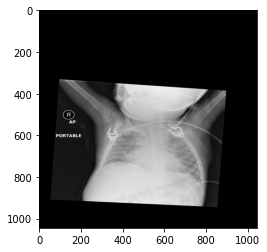

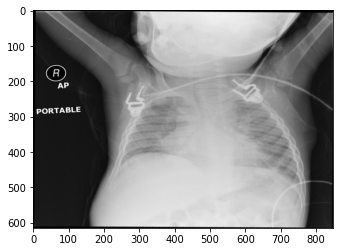

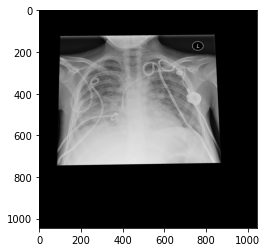

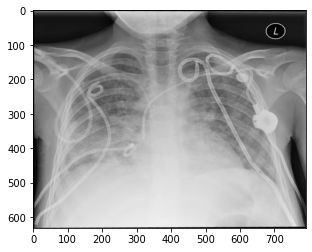

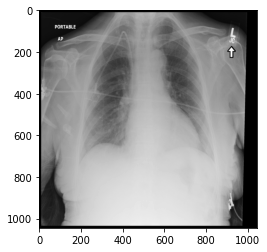

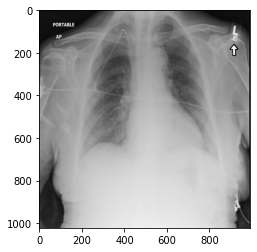

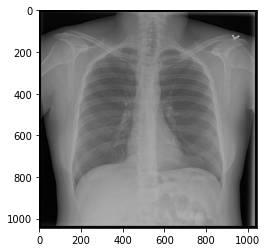

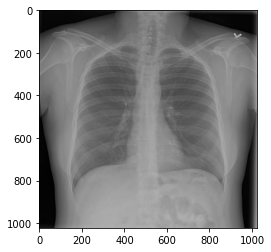

In [95]:
for image in (real_bad, bad, medium, good):
  plt.imshow(image, cmap="gray")
  plt.show()
  plt.imshow(perspective_correction(image), cmap="gray")
  plt.show()